In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime

pd.set_option('max_columns', 30)

from jbfg.pandas_utils import *

In [2]:
# 6개 데이터 읽어오기
products_info = get_df('select * from products_info', 'l2_jbwc_extnl')
train_x_past = get_df('select * from train_x_past', 'l2_jbwc_extnl')
train_x_current = get_df('select * from train_x_current', 'l2_jbwc_extnl')
train_y = get_df('select * from train_y', 'l2_jbwc_extnl')
test_x_past = get_df('select * from test_x_past', 'l2_jbwc_extnl')
test_x_current = get_df('select * from test_x_current', 'l2_jbwc_extnl')

원본데이터 보존을 위해 products, train data에 대해 copy 생성

In [3]:
products_info_copy = products_info.copy()
train_x_past_copy = train_x_past.copy()
train_x_current_copy = train_x_current.copy()

# 데이터살펴보기

## products_info
- product_id : 상품ID
- name : 상품명
- category_id : 분류ID
- division_id : 담당부서ID
- category_name : 분류명
- division_name : 담당부서명

In [4]:
products_info_copy.shape

(100, 6)

In [5]:
products_info_copy.nunique()

product_id       100
name             100
category_id       21
division_id        9
category_name     21
division_name      9
dtype: int64

-> product_id, name 중복 없음 확인

In [6]:
products_info_copy[['division_name','category_name']].value_counts().sort_index()

division_name  category_name                
bakery         bread                             1
beverages      refrigerated                      1
               soft drinks                       1
               water seltzer sparkling water     5
canned goods   canned meals beans                1
dairy eggs     butter                            2
               cream                             2
               eggs                              2
               milk                              5
               packaged cheese                   4
               soy lactosefree                   3
deli           fresh dips tapenades              1
               lunch meat                        1
frozen         frozen produce                    2
meat seafood   packaged poultry                  1
pantry         oils vinegars                     1
produce        fresh fruits                     24
               fresh herbs                       3
               fresh vegetables      

-> 기존에 컬럼값이 밀려 이상치로 보였던 Clemetines Bag이 정상적으로 수정된 것을 확인함.

---

## train_dataset

### train_x_past: 5,859 고객들의 "과거"구매이력

- order id : 주문 id
- cstno: 고객id
- order_number: 고객별 주문서 순번(구매 일자별 순번)
- week_day: 구매요일(0 일요일)
- order_hour: 구매 시각
- order_interval: 직전 구매후 경과 일수
- add_order: 주문서 내 담긴 상품의 순번(구매 시 상품을 담은 순번)
- is_reordered: 재구매 여부
- product_id: 상품 id

In [7]:
train_x_past_copy.head(3)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
0,717029,196613,15,1,9,3.0,5,0,41220
1,2325772,196613,35,6,11,2.0,7,1,41220
2,642668,196613,69,2,16,2.0,11,1,4210


In [8]:
train_x_past_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253972 entries, 0 to 1253971
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   order_id        1253972 non-null  object
 1   cstno           1253972 non-null  object
 2   order_number    1253972 non-null  object
 3   week_day        1253972 non-null  object
 4   order_hour      1253972 non-null  object
 5   order_interval  1253972 non-null  object
 6   add_order       1253972 non-null  object
 7   is_reordered    1253972 non-null  object
 8   product_id      1253972 non-null  object
dtypes: object(9)
memory usage: 86.1+ MB


In [9]:
train_x_past_copy.shape

(1253972, 9)

In [10]:
train_x_past_copy.describe()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
count,1253972,1253972,1253972,1253972,1253972,1253972,1253972,1253972,1253972
unique,341678,5859,99,7,24,32,93,2,100
top,2538975,150840,1,0,10,7.0,1,1,24852
freq,26,795,21686,233220,111896,166085,133657,1083774,74686


### train_x_current: 5,859 고객들의 "현재" 구매 정보 (product_id제외)

- order id : 주문 id
- cstno: 고객id
- order_number: 고객별 주문서 순번(구매 일자별 순번)
- week_day: 구매요일(0 일요일)
- order_hour: 구매 시각
- order_interval: 직전 구매후 경과 일수
- add_order: 주문서 내 담긴 상품의 순번(구매 시 상품을 담은 순번)
- is_reordered: 재구매 여부

In [11]:
train_x_current_copy.head()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered
0,806422,41116,47,5,18,3.0,4,1
1,2146033,127113,45,1,10,7.0,24,1
2,3055498,140168,45,5,10,26.0,11,1
3,3267527,60604,52,0,16,8.0,2,1
4,3125992,136554,46,4,9,5.0,2,0


In [12]:
train_x_current_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24424 entries, 0 to 24423
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        24424 non-null  object
 1   cstno           24424 non-null  object
 2   order_number    24424 non-null  object
 3   week_day        24424 non-null  object
 4   order_hour      24424 non-null  object
 5   order_interval  24424 non-null  object
 6   add_order       24424 non-null  object
 7   is_reordered    24424 non-null  object
dtypes: object(8)
memory usage: 1.5+ MB


In [13]:
train_x_current_copy.shape

(24424, 8)

In [14]:
train_x_current_copy.describe()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered
count,24424,24424,24424,24424,24424,24424,24424,24424
unique,5859,5859,58,7,24,31,55,2
top,736120,148812,100,0,10,7.0,2,1
freq,24,24,2060,6806,2002,3825,2404,22987


train_x_current 데이터 "현재"의 정의는? => 한 고객번호 예시로 파악해보기

In [15]:
train_x_past_copy.loc[train_x_past_copy['cstno'] == '196613'].sort_values('order_number')

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
57,1175721,196613,1,6,13,,10,0,24184
185,1175721,196613,1,6,13,,8,0,24852
112,1175721,196613,1,6,13,,5,0,17794
197,2914937,196613,11,6,10,1.0,5,1,24852
31,2914937,196613,11,6,10,1.0,11,0,46906
...,...,...,...,...,...,...,...,...,...
5,185079,196613,94,6,17,6.0,1,1,38689
173,185079,196613,94,6,17,6.0,3,1,24852
118,185079,196613,94,6,17,6.0,6,0,37646
135,564940,196613,97,6,15,5.0,1,1,27966


In [16]:
train_x_current_copy.loc[train_x_current_copy['cstno'] == '196613'].sort_values('order_number')

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered
1632,2414402,196613,100,6,13,5.0,4,1
24170,2414402,196613,100,6,13,5.0,1,1


가장 마지막 주문번호 "한 건"에 대한 정보로 보여짐. 다만 order_number가 연속적이지 않으므로 train_x_past의 order_number 자체가 중간에 누락이 있는지 먼저 확인<br>

    - train_x_past의 order_number 가 string타입이므로 일부 컬럼에 대한 타입 변경먼저 진행, 타입변경 함수로 생성

In [17]:
def type_change(df, col, to_type):
    #docstring
    '''dataframe, type변경할 컬럼명, 변경할 타입 입력'''
    df[col] = df[col].astype(to_type)
    
    return df

In [18]:
type_change(train_x_past_copy, ['order_number','order_hour','add_order'], 'int')
type_change(train_x_current_copy, ['order_number','order_hour','add_order'], 'int')

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered
0,806422,41116,47,5,18,3.0,4,1
1,2146033,127113,45,1,10,7.0,24,1
2,3055498,140168,45,5,10,26.0,11,1
3,3267527,60604,52,0,16,8.0,2,1
4,3125992,136554,46,4,9,5.0,2,0
...,...,...,...,...,...,...,...,...
24419,3184000,174046,100,5,7,2.0,12,1
24420,1754722,6710,100,5,11,3.0,21,1
24421,1076973,150840,100,0,13,0.0,18,1
24422,1247049,99707,100,1,13,3.0,6,1


**order interval은 오류발생하니 뒤에서 별도로 수정

order_number 중간 누락 확인을 위해 고객별 order_number최댓값과, 고유값의 count값을 대조

In [19]:
train_x_past_copy.groupby('cstno')['order_number'].max() == train_x_past_copy.groupby('cstno')['order_number'].nunique()

cstno
10000     False
100001    False
100046    False
100071    False
100108    False
          ...  
9981      False
99829      True
99887     False
99894      True
99901      True
Name: order_number, Length: 5859, dtype: bool

-> train_x_past의 order_number 자체에 누락이 있는 것으로 확인됨

    - 1) train_x_current에 고객별 order_id가 unique한지 확인
    - 2) train_x_current의 order_number > train_x_past의 마지막 order_number 인지 확인

In [20]:
train_x_current_copy.groupby(['cstno','order_id']).nunique().sum()

order_number       5859
week_day           5859
order_hour         5859
order_interval     5859
add_order         24424
is_reordered       6917
dtype: int64

In [21]:
tmp = train_x_current_copy.groupby('cstno')['order_number'].min() > train_x_past_copy.groupby('cstno')['order_number'].max()

In [22]:
tmp[tmp.values == False]

Series([], Name: order_number, dtype: bool)

-> 1), 2) 전부 확인 완료
   
    - train_x_past와 train_x_current를 합쳐서 분석하기로 함. 

In [23]:
# train_x_current와 train_y를 먼저 결함

train_current = pd.concat([train_x_current_copy,train_y], axis = 1)

# 먼저 past와 current 데이터에 last_order_yn 컬럼을 생성하여 두 dataset을 구분

train_x_past_copy['last_order_yn'] = 0
train_current['last_order_yn'] = 1

In [24]:
train_data = pd.concat([train_x_past_copy,train_current], axis = 0)

In [25]:
train_data.loc[train_data['cstno'] == '196613'].sort_values('order_number')

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn
57,1175721,196613,1,6,13,,10,0,24184,0
185,1175721,196613,1,6,13,,8,0,24852,0
112,1175721,196613,1,6,13,,5,0,17794,0
63,388865,196613,2,6,14,0.0,4,0,19660,0
51,388865,196613,2,6,14,0.0,5,0,46667,0
...,...,...,...,...,...,...,...,...,...,...
5,185079,196613,94,6,17,6.0,1,1,38689,0
135,564940,196613,97,6,15,5.0,1,1,27966,0
176,387070,196613,98,0,11,1.0,3,1,24852,0
1632,2414402,196613,100,6,13,5.0,4,1,43122,1


-> 전반적인 train dataset 결합 완료

---

## test_dataset

In [26]:
test_x_past.head()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
0,117004,186630,37,4,11,3.0,12,1,21709
1,128658,186630,20,2,10,6.0,4,1,21709
2,165882,186630,56,3,15,5.0,10,1,21709
3,180165,186630,17,1,16,4.0,4,1,21709
4,394948,186630,46,5,11,7.0,7,1,21709


In [27]:
test_x_past.shape

(541922, 9)

In [28]:
test_x_past.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541922 entries, 0 to 541921
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   order_id        541922 non-null  object
 1   cstno           541922 non-null  object
 2   order_number    541922 non-null  object
 3   week_day        541922 non-null  object
 4   order_hour      541922 non-null  object
 5   order_interval  541922 non-null  object
 6   add_order       541922 non-null  object
 7   is_reordered    541922 non-null  object
 8   product_id      541922 non-null  object
dtypes: object(9)
memory usage: 37.2+ MB


In [29]:
test_x_past.describe()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
count,541922,541922,541922,541922,541922,541922,541922,541922,541922
unique,156689,4141,99,7,24,32,79,2,100
top,3411224,176777,35,0,10,7.0,1,1,24852
freq,23,576,14268,114497,48032,88903,59334,443719,34287


In [30]:
test_x_current.head()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered
0,3384204,37987,38,5,16,13.0,9,1
1,2578612,169022,38,6,10,7.0,4,1
2,188887,200090,45,5,16,30.0,5,1
3,646772,149416,39,1,13,13.0,15,1
4,300214,113836,42,3,10,17.0,1,1


In [31]:
test_x_current.shape

(16126, 8)

In [32]:
test_x_current.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16126 entries, 0 to 16125
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        16126 non-null  object
 1   cstno           16126 non-null  object
 2   order_number    16126 non-null  object
 3   week_day        16126 non-null  object
 4   order_hour      16126 non-null  object
 5   order_interval  16126 non-null  object
 6   add_order       16126 non-null  object
 7   is_reordered    16126 non-null  object
dtypes: object(8)
memory usage: 1008.0+ KB


In [33]:
test_x_current.describe()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered
count,16126,16126,16126,16126,16126,16126,16126,16126
unique,4141,4141,63,7,24,31,52,2
top,265952,198856,41,0,13,7.0,1,1
freq,20,20,1877,4020,1410,2631,1639,14657


test data도 train dataset 과 유사한 것으로 보이니 뒤에서 일단은 추가가공 없이 train set으로 먼저 진행

---

## train dataset 가공

In [34]:
# train_data도 가공 전에 copy

train_data_copy = train_data.copy()

In [35]:
# train_data_copy의 index도 초기화 (past+current 결합하면서 index 중복이 발생함)

train_data_copy.loc[0,:]

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn
0,717029,196613,15,1,9,3.0,5,0,41220,0
0,806422,41116,47,5,18,3.0,4,1,21709,1


In [36]:
# train_data_copy의 index도 초기화 (past+current 결합하면서 index 중복이 발생함)

train_data_copy.reset_index(drop = True, inplace= True)
train_data_copy.loc[0,:]

order_id          717029
cstno             196613
order_number          15
week_day               1
order_hour             9
order_interval       3.0
add_order              5
is_reordered           0
product_id         41220
last_order_yn          0
Name: 0, dtype: object

### 컬럼가공

In [37]:
dow = {0:'Sun', 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat'}

In [38]:
train_data_copy['week_day_nm'] = train_data_copy.replace({'week_day':dow})['week_day']

#### colum요건 확인 및 가공

##### add_order

In [39]:
train_data_copy.groupby(['cstno','order_id'])['add_order'].min()

cstno  order_id
10000  103998      3
       1090401     1
       1104652     2
       1125006     1
       1191621     2
                  ..
99901  712543      2
       748340      5
       774765      3
       919399      1
       921228      2
Name: add_order, Length: 347537, dtype: int64

    -> 고객별 min(add_order) 가 1이 아닌 것들도 있음 -> 장바구니에 넣고 구매는 하지 않은 것으로 추정됨
    고객/주문번호별로 add_order 1~n 새로 생성

In [40]:
# row_number는 계속해서 필요하게 될 수 있으니 함수로 생성

def row_number(df, new_col, base_col, asc, agg_col):
    #docstring
    '''dataframe, new_col, base_col, asc, agg_col
    ex_train_x_past, 'cst_rn', ['order_number','add_order'], [True, True], 'cstno'
       df['cst_rn'] = df.sort_values(['order_number','add_order'], ascending=[True,True]).groupby('cstno').cumcount() + 1 '''
    #고객별 order 순서컬럼 생성(order_number + adj_add_order)
    df[new_col] = df.sort_values(base_col, ascending=asc).groupby(agg_col).cumcount() + 1    
    return df

In [41]:
row_number(train_data_copy, 'add_order_2','add_order', True, ['cstno','order_number'])

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn,week_day_nm,add_order_2
0,717029,196613,15,1,9,3.0,5,0,41220,0,1,1
1,2325772,196613,35,6,11,2.0,7,1,41220,0,6,2
2,642668,196613,69,2,16,2.0,11,1,4210,0,2,3
3,1326515,196613,61,3,19,3.0,3,1,4210,0,3,1
4,1437845,196613,36,3,15,4.0,16,0,4210,0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1278391,3184000,174046,100,5,7,2.0,12,1,24852,1,5,5
1278392,1754722,6710,100,5,11,3.0,21,1,24852,1,5,6
1278393,1076973,150840,100,0,13,0.0,18,1,24852,1,0,9
1278394,1247049,99707,100,1,13,3.0,6,1,24852,1,1,2


    → add_order_2는 생성완료
    order_number는 누락이 없을까?

##### order_number

In [42]:
train_data_copy.groupby('cstno')['order_number'].max() == train_data_copy.groupby('cstno')['order_number'].nunique()

cstno
10000     False
100001    False
100046    False
100071    False
100108    False
          ...  
9981      False
99829      True
99887     False
99894      True
99901     False
Name: order_number, Length: 5859, dtype: bool

-> order_number 최댓값 != 갯수 → order_number도 중간에 누락 → 주문취소 등으로 추정됨<br>
고객, order별 rn을 잡기 위해 order_number_2 컬럼 생성

order_number_2를 생성할 임시 테이블 생성

In [43]:
tmp_order_number_rn = train_data_copy[['cstno','order_id','order_number','add_order','add_order_2']].sort_values(['cstno','order_number','add_order_2'])
tmp_order_number_rn.reset_index(drop = True, inplace = True)

In [44]:
st = datetime.now()

new_orders = []
for idx, row in tmp_order_number_rn.iterrows():
    if idx == 0:
        new_order = 1
    elif prior_cstno != row['cstno']:
        new_order = 1
    elif prior_order_id == row['order_id']:
        new_order = prior_new_order_number
    else:
        new_order = prior_new_order_number + 1
    
    prior_cstno = row['cstno']
    prior_order_id = row['order_id']
    prior_new_order_number = new_order
    
    new_orders.append(new_order)

tmp_order_number_rn['order_number_2'] = new_orders    
print(datetime.now() - st)

0:01:22.067996


In [45]:
tmp_order_number_rn.loc[tmp_order_number_rn['cstno'] == '196613'].head(20)

,cstno,order_id,order_number,add_order,add_order_2,order_number_2
667680,196613,1175721,1,5,1,1
667681,196613,1175721,1,8,2,1
667682,196613,1175721,1,10,3,1
667683,196613,388865,2,4,1,2
667684,196613,388865,2,5,2,2
667685,196613,388865,2,6,3,2
667686,196613,388865,2,7,4,2
667687,196613,860319,3,4,1,3
667688,196613,860319,3,5,2,3
667689,196613,860319,3,7,3,3


생성된 order_number_2를 train_x_past_copy와 조인

In [46]:
train_data_copy = pd.merge(left = train_data_copy, right = tmp_order_number_rn, how = 'left', on = ['cstno','order_id','order_number','add_order_2'])

In [47]:
train_data_copy.head(2)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order_x,is_reordered,product_id,last_order_yn,week_day_nm,add_order_2,add_order_y,order_number_2
0,717029,196613,15,1,9,3.0,5,0,41220,0,1,1,5,12
1,2325772,196613,35,6,11,2.0,7,1,41220,0,6,2,7,26


In [48]:
#필요없는 컬럼 제거
train_data_copy.drop('add_order_y', axis = 1, inplace=True)

In [49]:
#column명 변경
train_data_copy.rename(columns = {'add_order_x':'add_order'}, inplace = True)

In [50]:
train_data_copy.sort_values(['cstno','order_number_2','add_order_2']).head(10)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn,week_day_nm,add_order_2,order_number_2
423552,1492646,10000,1,0,11,,1,0,21137,0,0,1,1
423390,1492646,10000,1,0,11,,3,0,5077,0,0,2,1
423511,1492646,10000,1,0,11,,4,0,47766,0,0,3,1
423454,1492646,10000,1,0,11,,7,0,27104,0,0,4,1
423418,1492646,10000,1,0,11,,8,0,26604,0,0,5,1
423501,1492646,10000,1,0,11,,10,0,22935,0,0,6,1
423306,1492646,10000,1,0,11,,12,0,15290,0,0,7,1
423597,1492646,10000,1,0,11,,13,0,24852,0,0,8,1
423527,1492646,10000,1,0,11,,19,0,21903,0,0,9,1
423288,1444722,10000,2,6,7,6.0,9,0,4799,0,6,1,2


##### is_reordered

In [51]:
train_data_copy[train_data_copy['is_reordered'] == '0'].value_counts().sum()

171635

In [52]:
train_data_copy['tmp'] = train_data_copy['cstno'] + train_data_copy['order_number'].astype('str')
train_data_copy['tmp'].nunique()

346717

171,635 != 346,717<br>
→ 고객+주문번호별 아닌 것 확인

In [53]:
train_data_copy['tmp2'] = train_data_copy['cstno'] + train_data_copy['product_id']
train_data_copy['tmp2'].nunique()

171635

171,635 == 171,635 <br>
is_reordered : 고객 + 상품별 기준인 것 확인<br>

In [54]:
#필요없어진 tmp, tmp2 컬럼 제거

train_data_copy.drop(['tmp','tmp2'], axis=1, inplace=True)

##### cst_rn 컬럼 생성

 -> 고객별 row_number생성

In [55]:
train_data_copy.loc[train_data_copy['cstno'] == '196613'].sort_values(['cstno','order_number_2','add_order_2'])

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn,week_day_nm,add_order_2,order_number_2
112,1175721,196613,1,6,13,,5,0,17794,0,6,1,1
185,1175721,196613,1,6,13,,8,0,24852,0,6,2,1
57,1175721,196613,1,6,13,,10,0,24184,0,6,3,1
63,388865,196613,2,6,14,0.0,4,0,19660,0,6,1,2
51,388865,196613,2,6,14,0.0,5,0,46667,0,6,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,185079,196613,94,6,17,6.0,6,0,37646,0,6,3,68
135,564940,196613,97,6,15,5.0,1,1,27966,0,6,1,69
176,387070,196613,98,0,11,1.0,3,1,24852,0,0,1,70
1278142,2414402,196613,100,6,13,5.0,1,1,24852,1,6,1,71


고객별 rn을 생성 -> 고객별 주문+상품 확인용

In [56]:
row_number(train_data_copy, 'cst_rn',['order_number_2','add_order_2'], [True,True], ['cstno'])

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn,week_day_nm,add_order_2,order_number_2,cst_rn
0,717029,196613,15,1,9,3.0,5,0,41220,0,1,1,12,34
1,2325772,196613,35,6,11,2.0,7,1,41220,0,6,2,26,86
2,642668,196613,69,2,16,2.0,11,1,4210,0,2,3,53,163
3,1326515,196613,61,3,19,3.0,3,1,4210,0,3,1,47,146
4,1437845,196613,36,3,15,4.0,16,0,4210,0,3,3,27,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278391,3184000,174046,100,5,7,2.0,12,1,24852,1,5,5,100,709
1278392,1754722,6710,100,5,11,3.0,21,1,24852,1,5,6,100,535
1278393,1076973,150840,100,0,13,0.0,18,1,24852,1,0,9,100,804
1278394,1247049,99707,100,1,13,3.0,6,1,24852,1,1,2,100,287


In [57]:
train_data_copy.loc[train_data_copy['cstno'] == '196613'].sort_values('cst_rn').head(10)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn,week_day_nm,add_order_2,order_number_2,cst_rn
112,1175721,196613,1,6,13,,5,0,17794,0,6,1,1,1
185,1175721,196613,1,6,13,,8,0,24852,0,6,2,1,2
57,1175721,196613,1,6,13,,10,0,24184,0,6,3,1,3
63,388865,196613,2,6,14,0.0,4,0,19660,0,6,1,2,4
51,388865,196613,2,6,14,0.0,5,0,46667,0,6,2,2,5
157,388865,196613,2,6,14,0.0,6,0,21903,0,6,3,2,6
101,388865,196613,2,6,14,0.0,7,0,31717,0,6,4,2,7
98,860319,196613,3,5,19,6.0,4,0,44359,0,5,1,3,8
93,860319,196613,3,5,19,6.0,5,0,28985,0,5,2,3,9
40,860319,196613,3,5,19,6.0,7,0,22825,0,5,3,3,10


→ cst_rn 잘 생성된 것 확인

<br><br>



### 데이터타입 변경
- order_interval int로 데이터타입 변경<br><br>
order_interval컬럼은 일부 float string 때문에 astype오류남 -> to_numeric으로 처리

In [58]:
train_data_copy['order_interval'] = pd.to_numeric(train_data_copy['order_interval'])

In [59]:
train_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1278396 entries, 0 to 1278395
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   order_id        1278396 non-null  object 
 1   cstno           1278396 non-null  object 
 2   order_number    1278396 non-null  int64  
 3   week_day        1278396 non-null  object 
 4   order_hour      1278396 non-null  int64  
 5   order_interval  1256710 non-null  float64
 6   add_order       1278396 non-null  int64  
 7   is_reordered    1278396 non-null  object 
 8   product_id      1278396 non-null  object 
 9   last_order_yn   1278396 non-null  int64  
 10  week_day_nm     1278396 non-null  object 
 11  add_order_2     1278396 non-null  int64  
 12  order_number_2  1278396 non-null  int64  
 13  cst_rn          1278396 non-null  int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 146.3+ MB


float로 변경하면서 null 발생 -- 최초 주문 건에는 order_interval이 없기때문

In [60]:
train_data_copy.isnull().sum()

order_id              0
cstno                 0
order_number          0
week_day              0
order_hour            0
order_interval    21686
add_order             0
is_reordered          0
product_id            0
last_order_yn         0
week_day_nm           0
add_order_2           0
order_number_2        0
cst_rn                0
dtype: int64

order_interval결측치 처리<br>
최초 주문건의 order_interval이 결측치이므로 0으로 대체하되, frist_order라는 신규컬럼 생성

In [61]:
#필요한 컬럼, order_interval이 null인 행만 추출
tmp_order_interval = train_data_copy[['cstno','cst_rn','order_interval']].loc[train_data_copy['order_interval'].isnull() == True]

In [62]:
tmp_order_interval.head()

,cstno,cst_rn,order_interval
57,196613,3,NaN
112,196613,1,NaN
185,196613,2,NaN
223,32775,1,NaN
258,32775,2,NaN


In [63]:
tmp_order_interval['first_order_yn'] = 1

In [64]:
tmp_order_interval.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21686 entries, 57 to 1253960
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cstno           21686 non-null  object 
 1   cst_rn          21686 non-null  int64  
 2   order_interval  0 non-null      float64
 3   first_order_yn  21686 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 847.1+ KB


In [65]:
len(tmp_order_interval[['cstno','cst_rn']].value_counts())

21686

→ tmp_order_interval의 cstno, cst_rn unique한 것 확인 -> merge의 key로 사용

In [66]:
#train_x_past_copy 에 fisrt_order_yn 추가
train_data_copy = pd.merge(left = train_data_copy, right = tmp_order_interval, how = 'left', on = ['cstno','cst_rn'])

#기존 order_interval_x의 결측치를 전부 0으로 대체
train_data_copy['order_interval_x'].fillna(0, inplace = True)

#first_order 결측치(최초주문 건 아닌 것) 전부 0으로 대체
train_data_copy['first_order_yn'].fillna(0, inplace = True)

#필요없어진 order_interval_y 컬럼 삭제, order_interval_x 컬럼명 수정
train_data_copy.drop('order_interval_y',axis=1,inplace=True)
train_data_copy.rename(columns = {'order_interval_x':'order_interval'}, inplace = True)

In [67]:
train_data_copy.isnull().sum()

order_id          0
cstno             0
order_number      0
week_day          0
order_hour        0
order_interval    0
add_order         0
is_reordered      0
product_id        0
last_order_yn     0
week_day_nm       0
add_order_2       0
order_number_2    0
cst_rn            0
first_order_yn    0
dtype: int64

In [68]:
train_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1278396 entries, 0 to 1278395
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   order_id        1278396 non-null  object 
 1   cstno           1278396 non-null  object 
 2   order_number    1278396 non-null  int64  
 3   week_day        1278396 non-null  object 
 4   order_hour      1278396 non-null  int64  
 5   order_interval  1278396 non-null  float64
 6   add_order       1278396 non-null  int64  
 7   is_reordered    1278396 non-null  object 
 8   product_id      1278396 non-null  object 
 9   last_order_yn   1278396 non-null  int64  
 10  week_day_nm     1278396 non-null  object 
 11  add_order_2     1278396 non-null  int64  
 12  order_number_2  1278396 non-null  int64  
 13  cst_rn          1278396 non-null  int64  
 14  first_order_yn  1278396 non-null  float64
dtypes: float64(2), int64(7), object(6)
memory usage: 156.1+ MB


<br>
결측치 처리 완료된 float컬럼 두 개를 int로 변경

In [69]:
type_change(train_data_copy, ['order_interval','first_order_yn'],'int')

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn,week_day_nm,add_order_2,order_number_2,cst_rn,first_order_yn
0,717029,196613,15,1,9,3,5,0,41220,0,1,1,12,34,0
1,2325772,196613,35,6,11,2,7,1,41220,0,6,2,26,86,0
2,642668,196613,69,2,16,2,11,1,4210,0,2,3,53,163,0
3,1326515,196613,61,3,19,3,3,1,4210,0,3,1,47,146,0
4,1437845,196613,36,3,15,4,16,0,4210,0,3,3,27,90,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278391,3184000,174046,100,5,7,2,12,1,24852,1,5,5,100,709,0
1278392,1754722,6710,100,5,11,3,21,1,24852,1,5,6,100,535,0
1278393,1076973,150840,100,0,13,0,18,1,24852,1,0,9,100,804,0
1278394,1247049,99707,100,1,13,3,6,1,24852,1,1,2,100,287,0


In [70]:
train_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1278396 entries, 0 to 1278395
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   order_id        1278396 non-null  object
 1   cstno           1278396 non-null  object
 2   order_number    1278396 non-null  int64 
 3   week_day        1278396 non-null  object
 4   order_hour      1278396 non-null  int64 
 5   order_interval  1278396 non-null  int64 
 6   add_order       1278396 non-null  int64 
 7   is_reordered    1278396 non-null  object
 8   product_id      1278396 non-null  object
 9   last_order_yn   1278396 non-null  int64 
 10  week_day_nm     1278396 non-null  object
 11  add_order_2     1278396 non-null  int64 
 12  order_number_2  1278396 non-null  int64 
 13  cst_rn          1278396 non-null  int64 
 14  first_order_yn  1278396 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 156.1+ MB


<br><Br>

### products_info와 merge

In [71]:
#merge 전에 중복체크위해 shape확인
train_data_copy.shape

(1278396, 15)

In [72]:
train_data_copy = pd.merge(left = train_data_copy, right = products_info_copy, how = 'left', on = 'product_id')

In [73]:
#혹시 중복 난 row 있는지 확인

train_data_copy.shape

(1278396, 20)

In [74]:
train_data_copy[train_data_copy['cstno'] == '196613'].sort_values('cst_rn').head(10)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn,week_day_nm,add_order_2,order_number_2,cst_rn,first_order_yn,name,category_id,division_id,category_name,division_name
112,1175721,196613,1,6,13,0,5,0,17794,0,6,1,1,1,1,Carrots,83,4,fresh vegetables,produce
185,1175721,196613,1,6,13,0,8,0,24852,0,6,2,1,2,1,Banana,24,4,fresh fruits,produce
57,1175721,196613,1,6,13,0,10,0,24184,0,6,3,1,3,1,Red Peppers,83,4,fresh vegetables,produce
63,388865,196613,2,6,14,0,4,0,19660,0,6,1,2,4,0,Spring Water,115,7,water seltzer sparkling water,beverages
51,388865,196613,2,6,14,0,5,0,46667,0,6,2,2,5,0,Organic Ginger Root,83,4,fresh vegetables,produce
157,388865,196613,2,6,14,0,6,0,21903,0,6,3,2,6,0,Organic Baby Spinach,123,4,packaged vegetables fruits,produce
101,388865,196613,2,6,14,0,7,0,31717,0,6,4,2,7,0,Organic Cilantro,16,4,fresh herbs,produce
98,860319,196613,3,5,19,6,4,0,44359,0,5,1,3,8,0,Organic Small Bunch Celery,83,4,fresh vegetables,produce
93,860319,196613,3,5,19,6,5,0,28985,0,5,2,3,9,0,Michigan Organic Kale,83,4,fresh vegetables,produce
40,860319,196613,3,5,19,6,7,0,22825,0,5,3,3,10,0,Organic D'Anjou Pears,24,4,fresh fruits,produce


→ train dataset 가공완료

가공완료된 train data 를 기존처럼 past, current 분리한 후 EDA 진행

In [75]:
# 필요없는 컬럼 제거
train_data_copy.drop(['add_order','order_number'], axis = 1, inplace = True)

In [76]:
#column명 변경
train_data_copy.rename(columns = {'add_order_2':'add_order', 'order_number_2':'order_number'}, inplace = True)

In [77]:
train_new_past = train_data_copy.loc[train_data_copy['last_order_yn'] == 0]
train_new_current = train_data_copy.loc[train_data_copy['last_order_yn'] == 1]

---

# EDA

In [78]:
train_new_past.head(3)

,order_id,cstno,week_day,order_hour,order_interval,is_reordered,product_id,last_order_yn,week_day_nm,add_order,order_number,cst_rn,first_order_yn,name,category_id,division_id,category_name,division_name
0,717029,196613,1,9,3,0,41220,0,1,1,12,34,0,Organic Romaine Lettuce,83,4,fresh vegetables,produce
1,2325772,196613,6,11,2,1,41220,0,6,2,26,86,0,Organic Romaine Lettuce,83,4,fresh vegetables,produce
2,642668,196613,2,16,2,1,4210,0,2,3,53,163,0,Whole Milk,84,16,milk,dairy eggs


train data의 key는 cstno, order_id, product_id. 최종적으로 product_id를 예측해야하므로 cstno, product_id 별 특성 확인

In [79]:
# int형 reorder 컬럼생성 - reorder 집계용

train_new_past['is_reordered_int'] = train_new_past['is_reordered'].astype('int')

/opt/conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## 구매현황

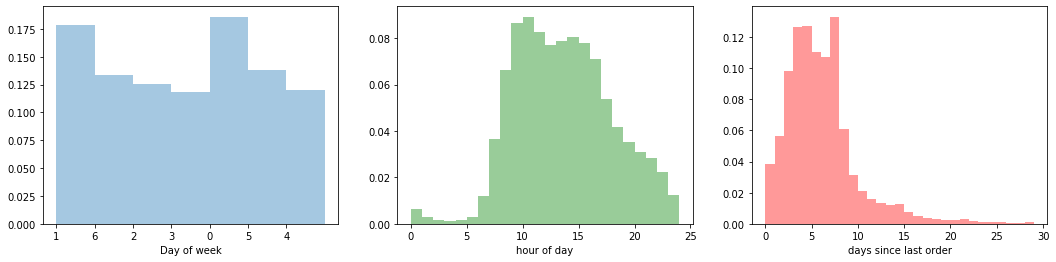

In [80]:
fig, ax = plt.subplots(1,3, figsize = (18,4))
ax = ax.ravel()

# 요일별 주문현황
ax[0].hist(x = train_new_past['week_day'], bins = range(0,8,1), alpha = 0.4, density = True)
ax[0].set_xlabel('Day of week')

# 시간대별 주문현황
ax[1].hist(x = train_new_past['order_hour'], color = 'green', bins = range(0,25,1), alpha = 0.4, density = True)
ax[1].set_xlabel('hour of day')

# 주문간격별 주문현황
ax[2].hist(x = train_new_past['order_interval'], color = 'red', bins = range(0,train_new_past['order_interval'].max(),1), alpha = 0.4, density = True)
ax[2].set_xlabel('days since last order')

plt.show()

### week_day 기준

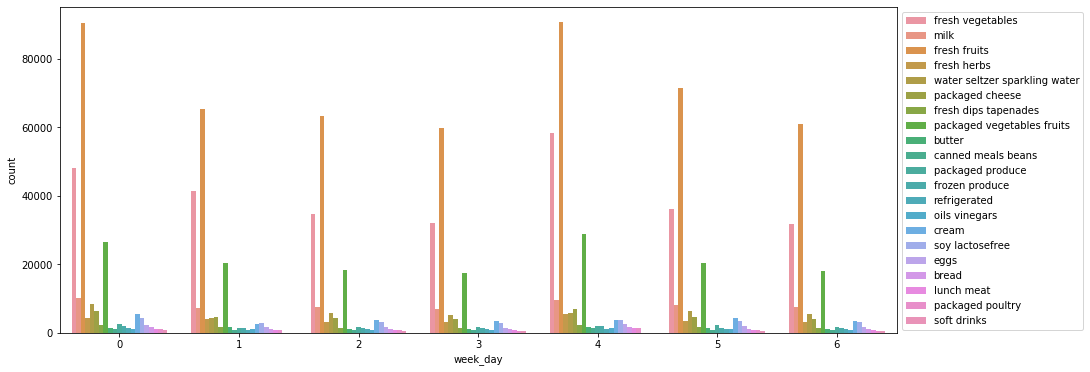

In [81]:
# 총 구매횟수 기준
fig, axes = plt.subplots(figsize = (15,6))

sns.countplot(ax = axes, x = 'week_day', hue = 'category_name', data = train_new_past)
axes.set_xticklabels(train_new_past.sort_values('week_day')['week_day_nm'].unique())
plt.legend(loc = 2, bbox_to_anchor = (1,1))

plt.show()

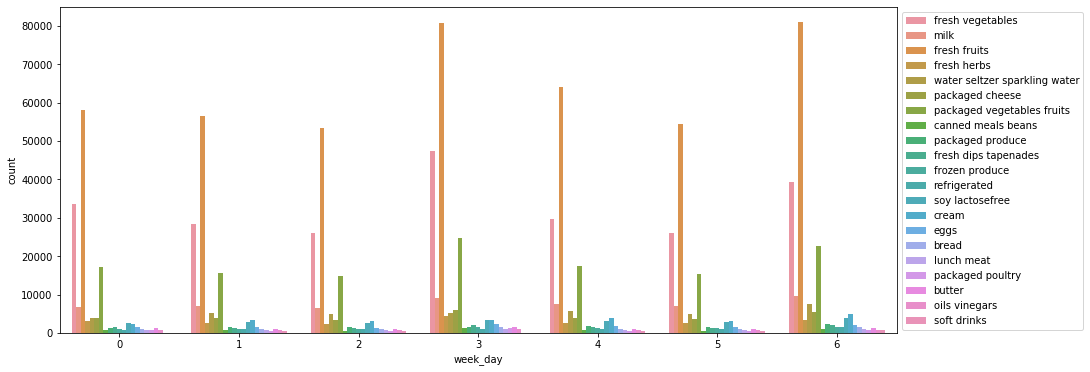

In [82]:
# 재구매기준
fig, axes = plt.subplots(figsize = (15,6))

sns.countplot(ax = axes, x = 'week_day', hue = 'category_name', data = train_new_past.loc[train_new_past['is_reordered']=='1'])
axes.set_xticklabels(train_new_past.sort_values('week_day')['week_day_nm'].unique())
plt.legend(loc = 2, bbox_to_anchor = (1,1))

plt.show()

비중이 높은 fresh_vege, fresh_fruits 제외

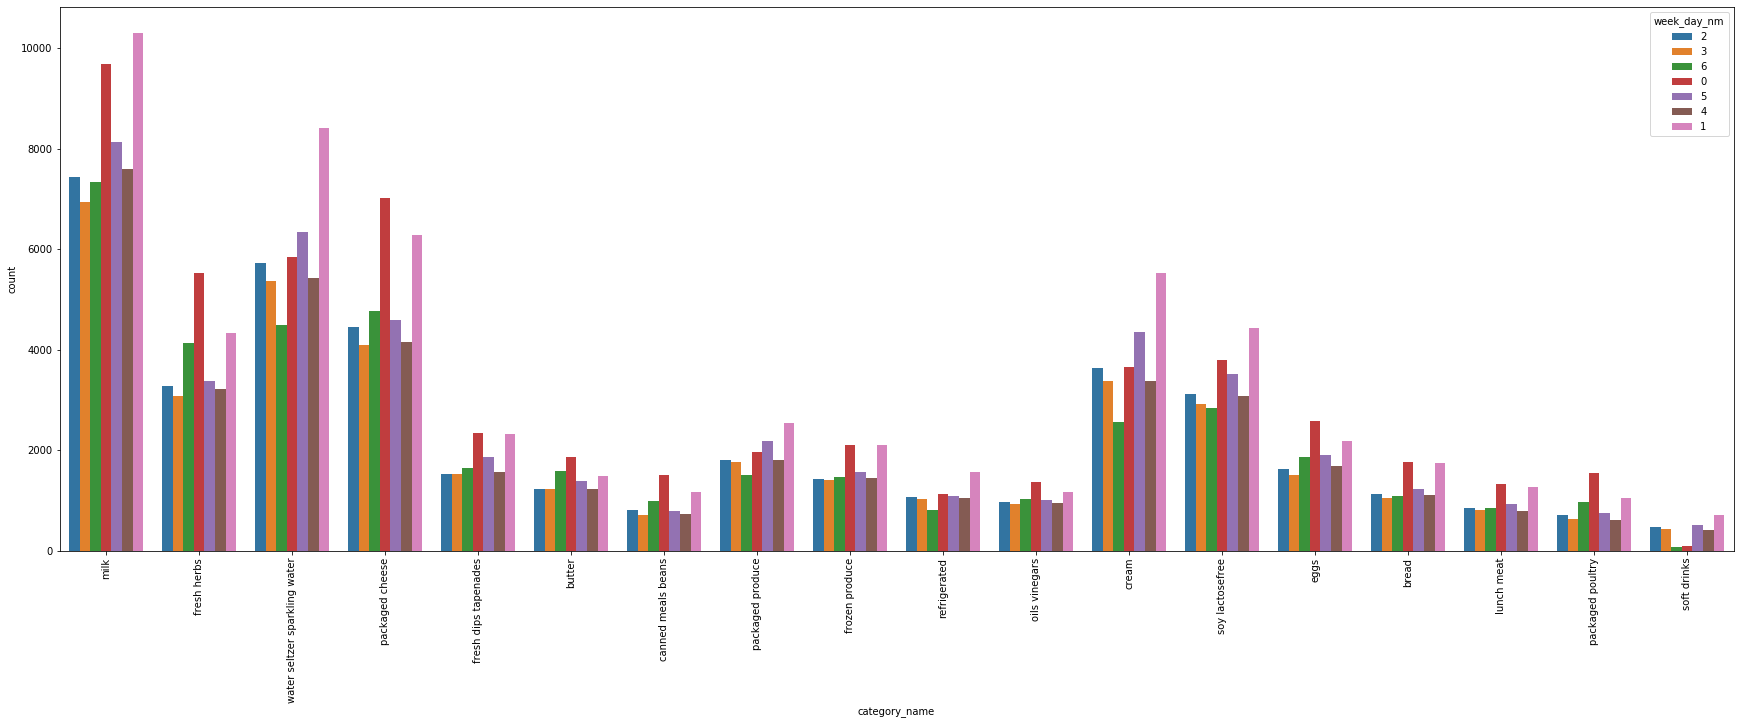

In [83]:
fig, axes = plt.subplots(figsize = (30,10))
# ax = ax.ravel()

sns.countplot(ax = axes, x = 'category_name', hue = 'week_day_nm', data = train_new_past.loc[(train_new_past['category_name'] != 'fresh vegetables') & (train_new_past['category_name'] != 'fresh fruits')& (train_new_past['category_name'] != 'packaged vegetables fruits')])
plt.xticks(rotation = 90)
# plt.legend(loc = 2, bbox_to_anchor = (1,1))

plt.show()

모든 카테고리의 최대 구매횟수가 포함된 요일이 일,월뿐이기 때문에 유의미하지않음

### order hour기준

In [84]:
hour_tmp = train_new_past.groupby(['cstno','name'])['order_hour'].mean()

In [85]:
hour_tmp = pd.DataFrame(hour_tmp)
hour_tmp.reset_index(inplace = True)
hour_tmp.head()

,cstno,name,order_hour
0,10000,100% Whole Wheat Bread,10.341463
1,10000,Bag of Organic Bananas,12.000000
2,10000,Banana,10.500000
3,10000,Carrots,13.250000
4,10000,Extra Virgin Olive Oil,9.500000


In [86]:
hour_tmp.groupby('name').mean()['order_hour'].astype('int').unique()

array([13, 12])

In [87]:
hour_tmp.groupby('cstno').mean()['order_hour'].astype('int').unique()

array([11, 13, 14, 12, 10, 15, 17,  9, 16,  7,  8, 18, 19, 20,  3, 22])

상품별로는 주문시간에 차이가 없으나 고객별로는 차이가 있음 -> 고객 특성테이블 생성

## 고객별 주문현황

### 고객별 주문 시간

평균주문시간

In [88]:
cst_feature_info = pd.DataFrame(hour_tmp.groupby('cstno').mean()['order_hour'])
cst_feature_info.reset_index(inplace = True)
cst_feature_info.rename(columns = {'order_hour' : 'mean_order_hour'}, inplace = True)

In [89]:
cst_feature_info.head(3)

,cstno,mean_order_hour
0,10000,11.710890
1,100001,13.343696
2,100046,14.943764


In [90]:
cst_feature_info.shape

(5859, 2)

최빈값

In [91]:
hour_tmp_2 = train_new_past[['cstno','order_hour']].value_counts()
hour_tmp_2 = pd.DataFrame(hour_tmp_2)
hour_tmp_2.reset_index(inplace = True)

In [92]:
row_number(hour_tmp_2, 'rn', 0, False, 'cstno')

,cstno,order_hour,0,rn
0,41356,7,299,1
1,174046,7,258,1
2,103593,10,248,1
3,156214,10,245,1
4,166786,16,217,1
...,...,...,...,...
83426,152996,23,1,16
83427,65765,23,1,16
83428,127988,16,1,18
83429,65765,20,1,17


In [93]:
hour_tmp_2 = hour_tmp_2[hour_tmp_2['rn'] == 1]

In [94]:
hour_tmp_2.shape

(5859, 4)

In [95]:
cst_feature_info = cst_feature_info.merge(hour_tmp_2[['cstno','order_hour']], on = 'cstno')
cst_feature_info.rename(columns = {'order_hour':'mode_cst_hour'}, inplace = True)
cst_feature_info.head()

,cstno,mean_order_hour,order_hour
0,10000,11.710890,8
1,100001,13.343696,10
2,100046,14.943764,16
3,100071,13.519928,16
4,100108,11.967736,12


### 고객별 주문건수

In [97]:
cst_cnt = train_new_past['cstno'].nunique()
mean_order_cnt = train_new_past.groupby('cstno')['order_number'].max().mean()

print('{0:,}명 고객의 평균 주문건수: {1:0.1f}'.format(cst_cnt, mean_order_cnt))

5,859명 고객의 평균 주문건수: 58.3


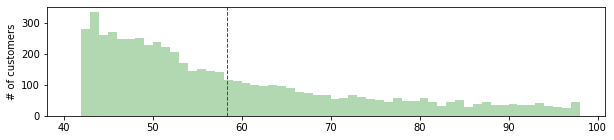

In [98]:
orders_per_cst = train_new_past.groupby('cstno')['order_number'].max()

fig, ax = plt.subplots(1,1, figsize=(10,2))

ax.hist(x = orders_per_cst, bins = range(orders_per_cst.min()-1, orders_per_cst.max(),1), color = 'green', alpha = 0.3)
ax.set_ylabel('# of customers')
ax.axvline(mean_order_cnt, color = 'r', linestyle = 'dashed', linewidth = 1)

고객특성 테이블에 추가

In [99]:
cst_feature_info = cst_feature_info.sort_values('cstno')
cst_feature_info['cst_orders_cnt'] = orders_per_cst.sort_index().values

In [100]:
cst_feature_info.head()

,cstno,mean_order_hour,order_hour,cst_orders_cnt
0,10000,11.710890,8,66
1,100001,13.343696,10,63
2,100046,14.943764,16,62
3,100071,13.519928,16,51
4,100108,11.967736,12,63


### 고객,주문별 평균 구매상품건수

In [101]:
order_cnt = train_new_past['order_id'].nunique()
mean_product_cnt = train_new_past.groupby(['cstno','order_id'])['add_order'].max().mean()

print('{0:,}건의 주문 당 평균 구매상품건수: {1:0.1f}'.format(order_cnt, mean_product_cnt))

341,678건의 주문 당 평균 구매상품건수: 3.7


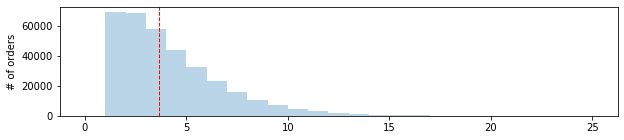

In [102]:
product_per_order = train_new_past.groupby(['cstno','order_id'])['add_order'].max()

fig, ax = plt.subplots(1,1, figsize=(10,2))

ax.hist(x = product_per_order, bins = range(product_per_order.min()-1, product_per_order.max(),1), alpha = 0.3)
ax.set_ylabel('# of orders')
ax.axvline(mean_product_cnt, color = 'r', linestyle = 'dashed', linewidth = 1)

고객특성 테이블에 추가

In [103]:
product_per_order = pd.DataFrame(product_per_order)
product_per_order = product_per_order.reset_index()
product_per_order.head()

,cstno,order_id,add_order
0,10000,103998,7
1,10000,1090401,5
2,10000,1104652,5
3,10000,1125006,6
4,10000,1191621,9


In [104]:
cst_feature_info = cst_feature_info.sort_values('cstno')
cst_feature_info['totl_prod_cnt_per_order'] = product_per_order.groupby('cstno')['add_order'].max().sort_index().values
cst_feature_info['mean_prod_cnt_per_order'] = product_per_order.groupby('cstno')['add_order'].mean().sort_index().values
cst_feature_info.head()

,cstno,mean_order_hour,order_hour,cst_orders_cnt,totl_prod_cnt_per_order,mean_prod_cnt_per_order
0,10000,11.710890,8,66,11,5.212121
1,100001,13.343696,10,63,12,5.460317
2,100046,14.943764,16,62,9,3.758065
3,100071,13.519928,16,51,11,4.313725
4,100108,11.967736,12,63,8,2.746032


### 고객별 재주문 현황

- is_reordered 컬럼은 cstno + product_id 기준
    - 고객별로 평소 동일한 상품을 반복해서 구매하는지, 새로운 상품을 구매하는지 파악

In [105]:
reorder_tmp = train_new_past.loc[train_new_past['is_reordered'] == '1'].groupby('cstno')['product_id'].nunique() / train_new_past.groupby('cstno')['product_id'].nunique()
reorder_tmp = pd.DataFrame(reorder_tmp)
reorder_tmp.reset_index(inplace = True)
reorder_tmp.rename(columns = {'product_id':'cst_reorder_ratio'}, inplace = True)

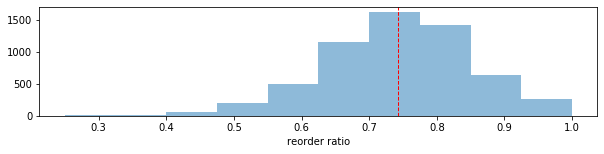

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))

ax.hist(reorder_tmp['cst_reorder_ratio'], alpha=0.5)
ax.set_xlabel('reorder ratio')
ax.axvline(reorder_tmp['cst_reorder_ratio'].mean(), color = 'r', linestyle='dashed', linewidth=1)

고객특성 테이블에 추가

In [107]:
cst_feature_info = cst_feature_info.merge(reorder_tmp, on = 'cstno')
cst_feature_info.head()

,cstno,mean_order_hour,order_hour,cst_orders_cnt,totl_prod_cnt_per_order,mean_prod_cnt_per_order,cst_reorder_ratio
0,10000,11.710890,8,66,11,5.212121,0.659091
1,100001,13.343696,10,63,12,5.460317,0.775000
2,100046,14.943764,16,62,9,3.758065,0.727273
3,100071,13.519928,16,51,11,4.313725,0.888889
4,100108,11.967736,12,63,8,2.746032,0.772727


### 고객별 주문간격

In [108]:
# order_interval 0 으로 설정했던 first_order 제외

order_interval_tmp = train_new_past.loc[train_new_past['first_order_yn'] == 0].groupby(['cstno','order_id'])['order_interval'].mean()
order_interval_tmp = order_interval_tmp.groupby('cstno').mean()
order_interval_tmp

cstno
10000     4.707692
100001    5.467742
100046    4.704918
100071    5.560000
100108    5.238095
            ...   
9981      7.276596
99829     8.523810
99887     3.965909
99894     7.000000
99901     7.543478
Name: order_interval, Length: 5859, dtype: float64

In [109]:
order_interval_tmp = pd.DataFrame(order_interval_tmp)
order_interval_tmp.reset_index(inplace = True)

In [110]:
order_interval_tmp.rename(columns = {'order_interval':'cst_order_interval'}, inplace = True)

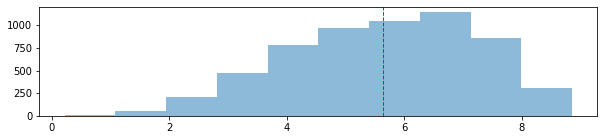

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))

ax.hist(order_interval_tmp['cst_order_interval'], alpha=0.5)
ax.axvline(order_interval_tmp['cst_order_interval'].mean(), color = 'r', linestyle='dashed', linewidth=1)

고객특성 테이블에 추가

In [112]:
cst_feature_info = cst_feature_info.merge(order_interval_tmp, on = 'cstno')
cst_feature_info.head()

,cstno,mean_order_hour,order_hour,cst_orders_cnt,totl_prod_cnt_per_order,mean_prod_cnt_per_order,cst_reorder_ratio,cst_order_interval
0,10000,11.710890,8,66,11,5.212121,0.659091,4.707692
1,100001,13.343696,10,63,12,5.460317,0.775000,5.467742
2,100046,14.943764,16,62,9,3.758065,0.727273,4.704918
3,100071,13.519928,16,51,11,4.313725,0.888889,5.560000
4,100108,11.967736,12,63,8,2.746032,0.772727,5.238095


## 상품별 주문현황

### division_name 기준 - div_tmp

In [113]:
div_tmp = train_new_past.groupby('division_name')['is_reordered_int'].agg(['count','sum'])
div_tmp = div_tmp.sort_values('count', ascending = False).reset_index()

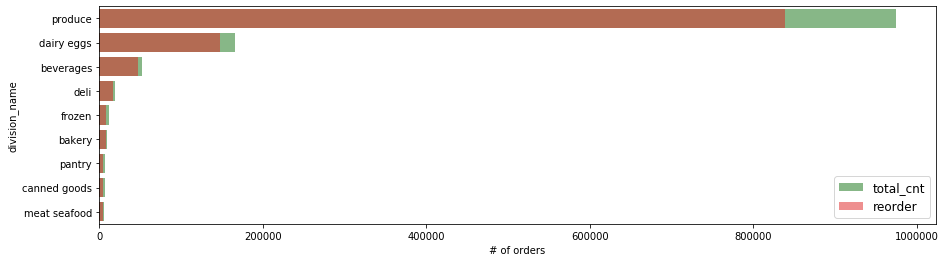

In [114]:
fig, ax = plt.subplots(figsize = (15,4))

ax = sns.barplot(y = div_tmp['division_name'][0:20],x = div_tmp['count'][0:20], color = 'green',alpha = 0.5, label = 'total_cnt')
ax = sns.barplot(y = div_tmp['division_name'][0:20],x = div_tmp['sum'][0:20], color = 'red', alpha = 0.5, label = 'reorder')
ax.set_ylabel('division_name')
ax.set_xlabel('# of orders')
ax.legend(loc = 4, prop = {'size':12})

plt.show()

### category_name 기준 - cat_tmp, top1

In [115]:
cat_tmp = train_new_past.groupby('category_name')['is_reordered_int'].agg(['count','sum'])
cat_tmp = cat_tmp.sort_values('count', ascending = False).reset_index()

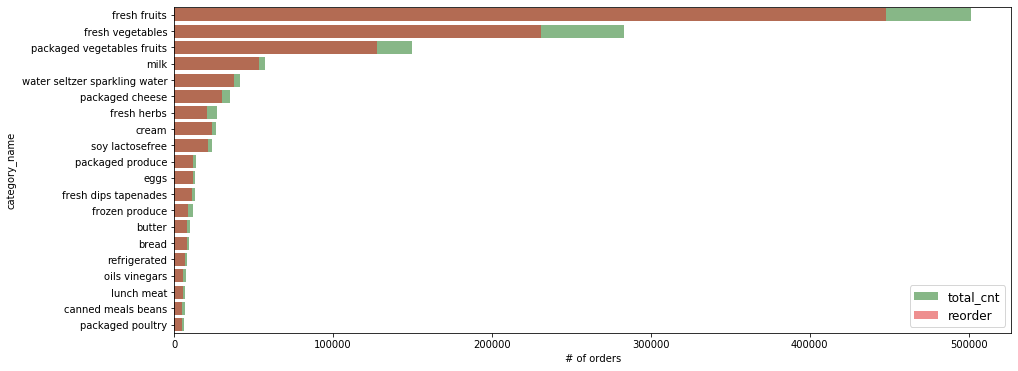

In [116]:
fig, ax = plt.subplots(figsize = (15,6))

ax = sns.barplot(y = cat_tmp['category_name'][0:20],x = cat_tmp['count'][0:20], color = 'green',alpha = 0.5, label = 'total_cnt')
ax = sns.barplot(y = cat_tmp['category_name'][0:20],x = cat_tmp['sum'][0:20], color = 'red', alpha = 0.5, label = 'reorder')
ax.set_ylabel('category_name')
ax.set_xlabel('# of orders')
ax.legend(loc = 4, prop = {'size':12})

plt.show()

In [117]:
cat_tmp['reorder_ratio'] = cat_tmp['sum'] / cat_tmp['count']
cat_tmp = cat_tmp.sort_values('reorder_ratio', ascending=False).reset_index()

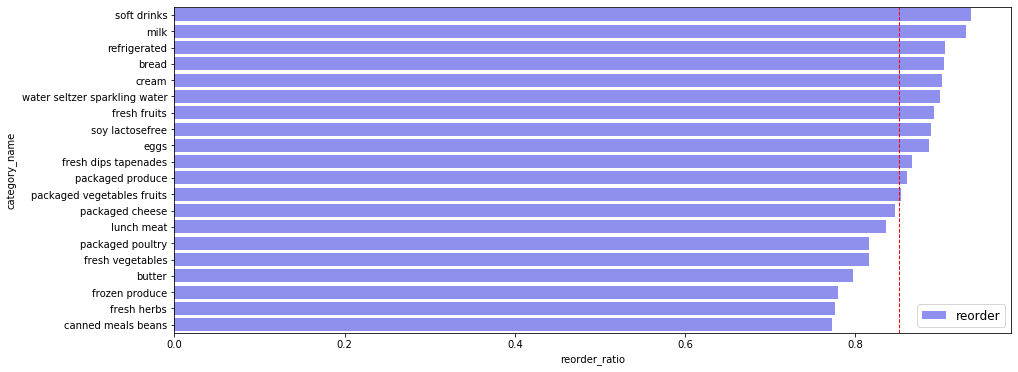

In [118]:
fig, ax = plt.subplots(figsize = (15,6))

ax = sns.barplot(y = cat_tmp['category_name'][0:20],x = cat_tmp['reorder_ratio'][0:20], color = 'blue', alpha = 0.5, label = 'reorder')
ax.set_ylabel('category_name')
ax.set_xlabel('reorder_ratio')
ax.legend(loc = 4, prop = {'size':12})

ax.axvline(cat_tmp['reorder_ratio'].mean() , color = 'r', linestyle = 'dashed', linewidth = 1)

plt.show()

In [119]:
#건수기반 top20
top_number = cat_tmp.sort_values('count', ascending = False)[['category_name']]
top_number.reset_index(drop = True, inplace = True)
top_number.rename(columns ={'category_name':'구매횟수기준'}, inplace = True)

#재구매율기반 top20
top_ratio = cat_tmp.sort_values('reorder_ratio', ascending = False)[['category_name']]
top_ratio.reset_index(drop = True, inplace = True)
top_ratio.rename(columns ={'category_name':'재구매율기준'}, inplace = True)

top_1 = pd.concat([top_number, top_ratio], axis = 1)

In [120]:
top_1

,구매횟수기준,재구매율기준
0,fresh fruits,soft drinks
1,fresh vegetables,milk
2,packaged vegetables fruits,refrigerated
3,milk,bread
4,water seltzer sparkling water,cream
5,packaged cheese,water seltzer sparkling water
6,fresh herbs,fresh fruits
7,cream,soy lactosefree
8,soy lactosefree,eggs
9,packaged produce,fresh dips tapenades


category 기준에서 구매횟수와 재구매율의 편차가 크므로 product 기준으로 파악

### product_name 기준 - prod_tmp

In [121]:
prod_tmp = train_new_past.groupby('name')['is_reordered_int'].agg(['count','sum'])
prod_tmp = prod_tmp.sort_values('count', ascending = False).reset_index()

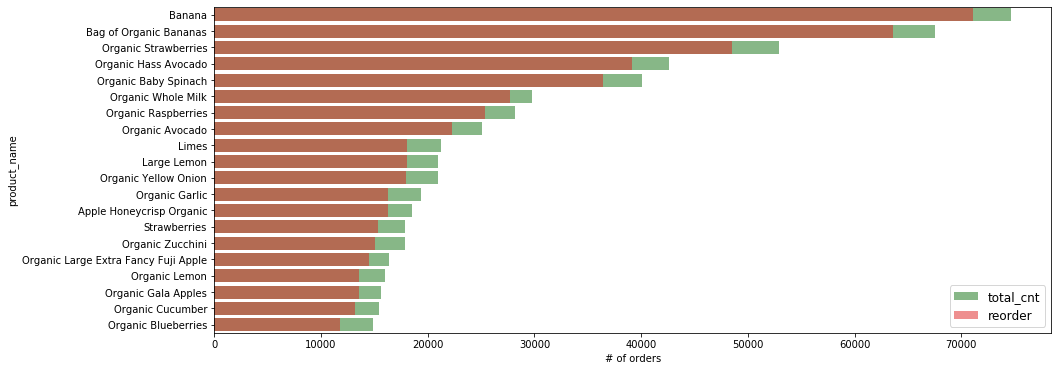

In [122]:
fig, ax = plt.subplots(figsize = (15,6))

ax = sns.barplot(y = prod_tmp['name'][0:20],x = prod_tmp['count'][0:20], color = 'green',alpha = 0.5, label = 'total_cnt')
ax = sns.barplot(y = prod_tmp['name'][0:20],x = prod_tmp['sum'][0:20], color = 'red', alpha = 0.5, label = 'reorder')
ax.set_ylabel('product_name')
ax.set_xlabel('# of orders')
ax.legend(loc = 4, prop = {'size':12})

plt.show()

In [123]:
prod_tmp['reorder_ratio'] = prod_tmp['sum'] / prod_tmp['count']
prod_tmp = prod_tmp.sort_values('reorder_ratio', ascending=False).reset_index(drop = True)

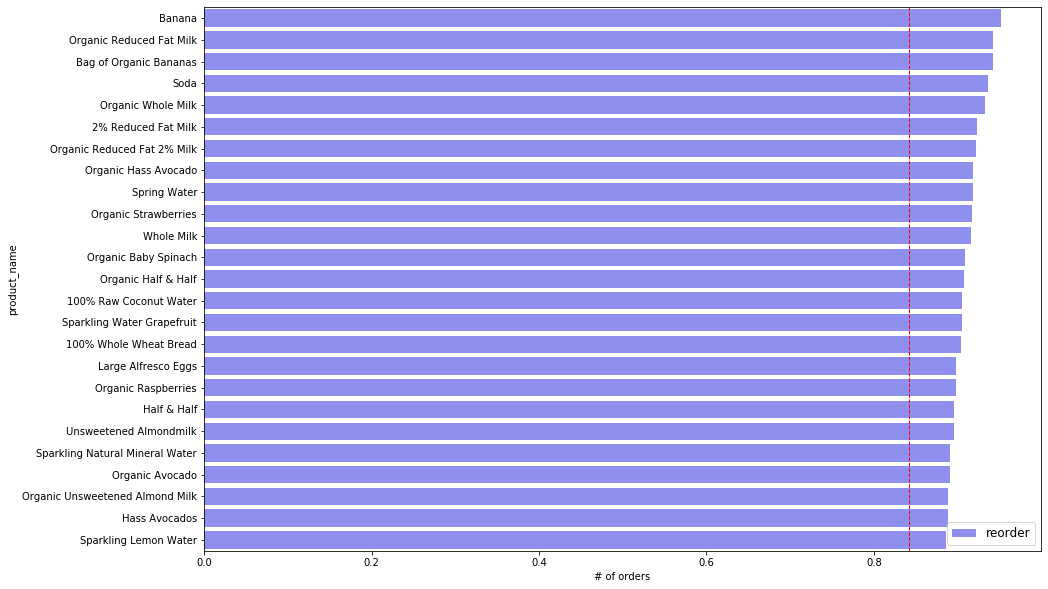

In [124]:
fig, ax = plt.subplots(figsize = (15,10))

ax = sns.barplot(y = prod_tmp['name'][0:25],x = prod_tmp['reorder_ratio'][0:25], color = 'blue', alpha = 0.5, label = 'reorder')
ax.set_ylabel('product_name')
ax.set_xlabel('# of orders')
ax.legend(loc = 4, prop = {'size':12})

ax.axvline(prod_tmp['reorder_ratio'].mean() , color = 'r', linestyle = 'dashed', linewidth = 1)

plt.show()

건수기반 rank와 재구매율기반 rank 에 차이가 있는 것으로 보여지므로 rank 비교

In [125]:
#건수기반
top_number_prod = prod_tmp.sort_values('count', ascending = False)
top_number_prod.reset_index(drop = True, inplace = True)
top_number_prod['rank'] = top_number_prod.index+1
top_number_prod.head()

,name,count,sum,reorder_ratio,rank
0,Banana,74686,71104,0.952039,1
1,Bag of Organic Bananas,67514,63601,0.942042,2
2,Organic Strawberries,52917,48516,0.916832,3
3,Organic Hass Avocado,42604,39136,0.918599,4
4,Organic Baby Spinach,40112,36444,0.908556,5


In [126]:
#재구매율기반
top_ratio_prod = prod_tmp.sort_values('reorder_ratio', ascending = False)
top_ratio_prod.reset_index(drop = True, inplace = True)
top_ratio_prod['rank'] = top_ratio_prod.index+1
top_ratio_prod.head()

,name,count,sum,reorder_ratio,rank
0,Banana,74686,71104,0.952039,1
1,Organic Reduced Fat Milk,8837,8327,0.942288,2
2,Bag of Organic Bananas,67514,63601,0.942042,3
3,Soda,2712,2539,0.936209,4
4,Organic Whole Milk,29757,27753,0.932655,5


In [129]:
order_prod_rank = top_number_prod.merge(top_ratio_prod[['name','rank']], on='name')
order_prod_rank['rank_diff'] = order_prod_rank['rank_x'] - order_prod_rank['rank_y']
order_prod_rank['rank_diff'] = order_prod_rank['rank_diff'].abs()
order_prod_rank.rename(columns = {'rank_x':'by_cnt_rank', 'rank_y':'by_re_ratio_rank'}, inplace = True)

In [132]:
order_prod_rank.loc[order_prod_rank['by_cnt_rank'] <= 20].sort_values(['rank_diff','by_re_ratio_rank']).head(20)

,name,count,sum,reorder_ratio,by_cnt_rank,by_re_ratio_rank,rank_diff
0,Banana,74686,71104,0.952039,1,1,0
1,Bag of Organic Bananas,67514,63601,0.942042,2,3,1
5,Organic Whole Milk,29757,27753,0.932655,6,5,1
3,Organic Hass Avocado,42604,39136,0.918599,4,8,4
2,Organic Strawberries,52917,48516,0.916832,3,10,7
4,Organic Baby Spinach,40112,36444,0.908556,5,12,7
6,Organic Raspberries,28207,25332,0.898075,7,18,11
15,Organic Large Extra Fancy Fuji Apple,16387,14477,0.883444,16,27,11
7,Organic Avocado,25046,22303,0.890482,8,22,14
17,Organic Gala Apples,15611,13599,0.871117,18,33,15


In [133]:
#category_name붙이기

order_prod_rank = order_prod_rank.merge(products_info[['name','division_name','category_name','product_id']], on = 'name')

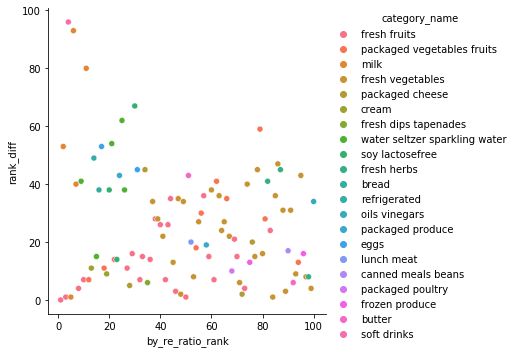

In [134]:
sns.relplot(x = 'by_re_ratio_rank',y ='rank_diff',hue = 'category_name', data = order_prod_rank)

In [135]:
#order_prod_rank 에 각 상품을 구매한 고객 수, 고객비중 추가

total_cst_cnt = train_new_past['cstno'].nunique()
prod_cst_cnt = train_new_past.groupby('name')['cstno'].nunique()
prod_cst_cnt = pd.DataFrame(prod_cst_cnt)
prod_cst_cnt.reset_index(inplace = True)
prod_cst_cnt['cst_ratio'] = prod_cst_cnt['cstno'] / total_cst_cnt
prod_cst_cnt.rename(columns = {'cstno':'cst_cnt'})

prod_cst_cnt = prod_cst_cnt.sort_values('cst_ratio', ascending = False).reset_index(drop = True)
prod_cst_cnt['cst_rank'] = prod_cst_cnt.index+1

In [136]:
prod_cst_cnt.head()

,name,cstno,cst_ratio,cst_rank
0,Organic Strawberries,4401,0.751152,1
1,Bag of Organic Bananas,3913,0.667861,2
2,Organic Baby Spinach,3668,0.626045,3
3,Banana,3582,0.611367,4
4,Organic Hass Avocado,3468,0.591910,5


In [137]:
prod_cst_cnt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       100 non-null    object 
 1   cstno      100 non-null    int64  
 2   cst_ratio  100 non-null    float64
 3   cst_rank   100 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 3.2+ KB


In [138]:
#order_prod_rank와 결합
prod_feature_info = order_prod_rank.merge(prod_cst_cnt[['name','cst_ratio','cst_rank']], on = 'name')
prod_feature_info.head(10)

,name,count,sum,reorder_ratio,by_cnt_rank,by_re_ratio_rank,rank_diff,division_name,category_name,product_id,cst_ratio,cst_rank
0,Banana,74686,71104,0.952039,1,1,0,produce,fresh fruits,24852,0.611367,4
1,Bag of Organic Bananas,67514,63601,0.942042,2,3,1,produce,fresh fruits,13176,0.667861,2
2,Organic Strawberries,52917,48516,0.916832,3,10,7,produce,fresh fruits,21137,0.751152,1
3,Organic Hass Avocado,42604,39136,0.918599,4,8,4,produce,fresh fruits,47209,0.591910,5
4,Organic Baby Spinach,40112,36444,0.908556,5,12,7,produce,packaged vegetables fruits,21903,0.626045,3
5,Organic Whole Milk,29757,27753,0.932655,6,5,1,dairy eggs,milk,27845,0.342038,32
6,Organic Raspberries,28207,25332,0.898075,7,18,11,produce,packaged vegetables fruits,27966,0.490698,11
7,Organic Avocado,25046,22303,0.890482,8,22,14,produce,fresh fruits,47766,0.468169,13
8,Limes,21216,18018,0.849265,9,44,35,produce,fresh fruits,26209,0.545827,6
9,Large Lemon,21012,18069,0.859937,10,38,28,produce,fresh fruits,47626,0.502304,10


In [139]:
#컬럼명 변경
prod_feature_info.rename(columns = {'count':'order_cnt', 'sum':'reorder_cnt'}, inplace = True)

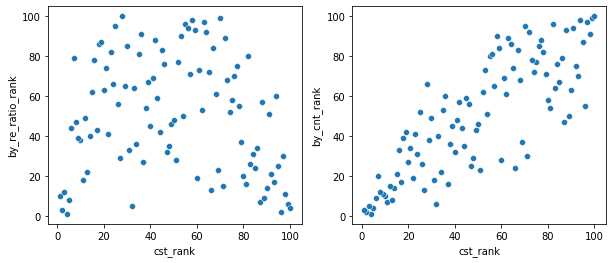

In [140]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
ax = ax.ravel()

sns.scatterplot(ax = ax[0], y = 'by_re_ratio_rank',x ='cst_rank', data = prod_feature_info)
sns.scatterplot(ax = ax[1], y = 'by_cnt_rank',x ='cst_rank', data = prod_feature_info)

plt.show()

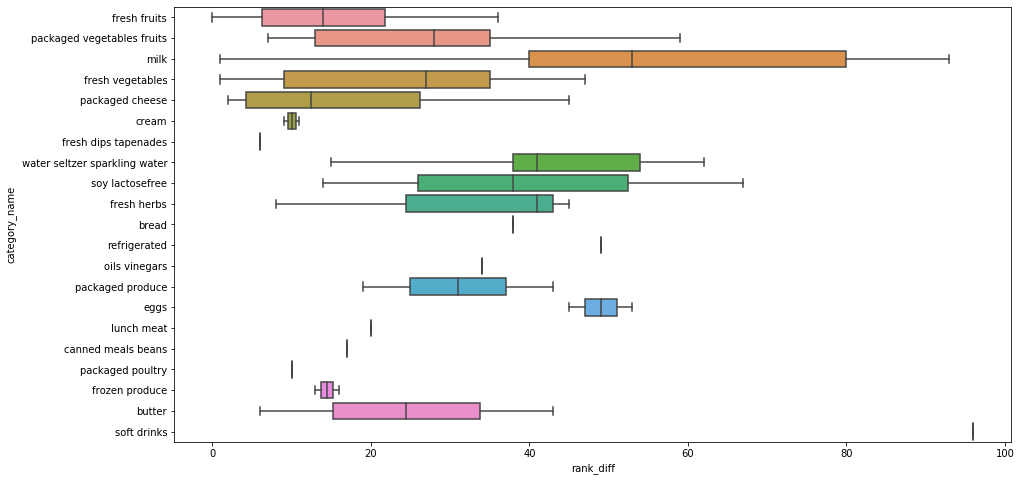

In [141]:
plt.figure(figsize = (15,8))
sns.boxplot(x = 'rank_diff',y ='category_name', data = prod_feature_info.sort_values('by_cnt_rank'), orient = 'h')
plt.show()

In [142]:
prod_feature_info.loc[prod_feature_info['category_name']=='milk']

,name,order_cnt,reorder_cnt,reorder_ratio,by_cnt_rank,by_re_ratio_rank,rank_diff,division_name,category_name,product_id,cst_ratio,cst_rank
5,Organic Whole Milk,29757,27753,0.932655,6,5,1,dairy eggs,milk,27845,0.342038,32
46,Organic Reduced Fat 2% Milk,10114,9318,0.921297,47,7,40,dairy eggs,milk,5785,0.135859,87
54,Organic Reduced Fat Milk,8837,8327,0.942288,55,2,53,dairy eggs,milk,38689,0.087046,96
90,Whole Milk,5149,4717,0.916100,91,11,80,dairy eggs,milk,4210,0.073733,98
98,2% Reduced Fat Milk,3547,3273,0.922752,99,6,93,dairy eggs,milk,23909,0.046766,99


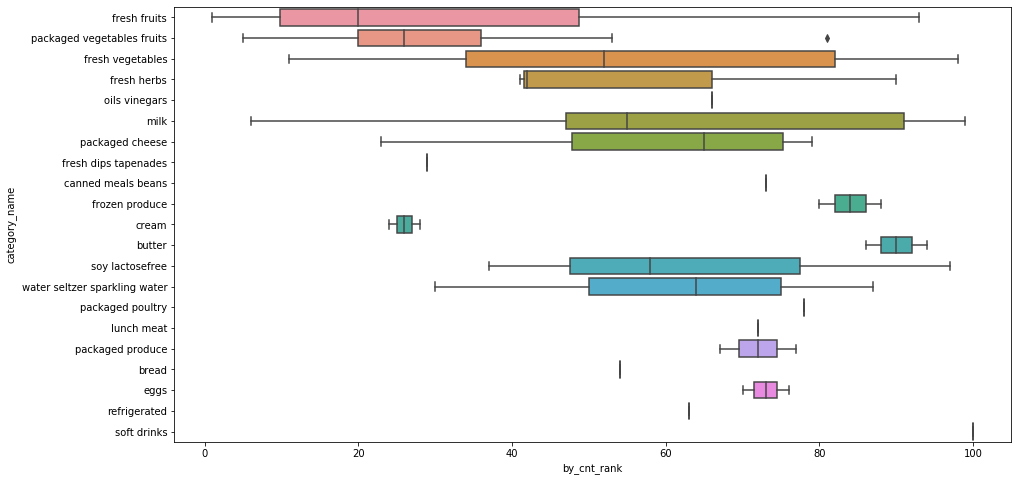

In [143]:
plt.figure(figsize = (15,8))
sns.boxplot(x = 'by_cnt_rank',y ='category_name', data = prod_feature_info.sort_values('cst_rank'), orient = 'h')
plt.show()

- 고객수rank 상위 category에서 동일 category 내 상품별로 편차가 큰 것으로 보여짐 (상품이 많고 , 많은 고객이 샀으니 당연한 결과일 수 있음)
- 한 category 안에 상품종류가 많은 fresh_fruits, fresh_vegetables는 예외
- 
    - fresh fruits, packaged vegetables fruits, fresh vegetables, milk, packaged cheese (상위10개 카테고리만)
    - category를 재정비할 필요가 있을까?

In [144]:
#가장 많은 고객이 구매한 top20상품
prod_feature_info.sort_values('cst_rank').head(20)

,name,order_cnt,reorder_cnt,reorder_ratio,by_cnt_rank,by_re_ratio_rank,rank_diff,division_name,category_name,product_id,cst_ratio,cst_rank
2,Organic Strawberries,52917,48516,0.916832,3,10,7,produce,fresh fruits,21137,0.751152,1
1,Bag of Organic Bananas,67514,63601,0.942042,2,3,1,produce,fresh fruits,13176,0.667861,2
4,Organic Baby Spinach,40112,36444,0.908556,5,12,7,produce,packaged vegetables fruits,21903,0.626045,3
0,Banana,74686,71104,0.952039,1,1,0,produce,fresh fruits,24852,0.611367,4
3,Organic Hass Avocado,42604,39136,0.918599,4,8,4,produce,fresh fruits,47209,0.591910,5
8,Limes,21216,18018,0.849265,9,44,35,produce,fresh fruits,26209,0.545827,6
19,Organic Blueberries,14859,11806,0.794535,20,79,59,produce,packaged vegetables fruits,39275,0.521079,7
11,Organic Garlic,19332,16280,0.842127,12,47,35,produce,fresh vegetables,24964,0.520908,8
10,Organic Yellow Onion,20977,17995,0.857844,11,39,28,produce,fresh vegetables,22935,0.508961,9
9,Large Lemon,21012,18069,0.859937,10,38,28,produce,fresh fruits,47626,0.502304,10


In [145]:
top5_cat = ['fresh vegetables','fresh fruits','packaged vegetables fruits','milk','water seltzer sparkling water']
prod_name_tmp = products_info.loc[products_info['category_name'].isin(top5_cat)]['name']
prod_name_tmp = pd.DataFrame(prod_name_tmp)
prod_name_tmp.reset_index(drop = True, inplace = True)
prod_name_tmp[prod_name_tmp['name'].str.contains('Organic')].count() / prod_name_tmp.shape[0]

name    0.555556
dtype: float64

유기농 제품의 비율 55.6%

In [146]:
#Organic이 많이 보임 -> 유기농상품의 구매비중은?
prod_feature_info.loc[prod_feature_info['name'].str.contains('Organic')]['cst_ratio'].sum()

17.158559481140124

59.1%의 고객이 유기농제품에 관심이 있음

In [147]:
# 유기농상품여부 추가
organic_yn = prod_feature_info['name'].str.contains('Organic').astype('int')
prod_feature_info['organic_yn'] = organic_yn

prod_feature_info.head(10)

,name,order_cnt,reorder_cnt,reorder_ratio,by_cnt_rank,by_re_ratio_rank,rank_diff,division_name,category_name,product_id,cst_ratio,cst_rank,organic_yn
0,Banana,74686,71104,0.952039,1,1,0,produce,fresh fruits,24852,0.611367,4,0
1,Bag of Organic Bananas,67514,63601,0.942042,2,3,1,produce,fresh fruits,13176,0.667861,2,1
2,Organic Strawberries,52917,48516,0.916832,3,10,7,produce,fresh fruits,21137,0.751152,1,1
3,Organic Hass Avocado,42604,39136,0.918599,4,8,4,produce,fresh fruits,47209,0.591910,5,1
4,Organic Baby Spinach,40112,36444,0.908556,5,12,7,produce,packaged vegetables fruits,21903,0.626045,3,1
5,Organic Whole Milk,29757,27753,0.932655,6,5,1,dairy eggs,milk,27845,0.342038,32,1
6,Organic Raspberries,28207,25332,0.898075,7,18,11,produce,packaged vegetables fruits,27966,0.490698,11,1
7,Organic Avocado,25046,22303,0.890482,8,22,14,produce,fresh fruits,47766,0.468169,13,1
8,Limes,21216,18018,0.849265,9,44,35,produce,fresh fruits,26209,0.545827,6,0
9,Large Lemon,21012,18069,0.859937,10,38,28,produce,fresh fruits,47626,0.502304,10,0


## 고객특성 테이블 + 상품특성 테이블 연결

In [148]:
prod_per_cst = train_new_past[['cstno','product_id']].value_counts()
prod_per_cst = pd.DataFrame(prod_per_cst)
prod_per_cst.reset_index(inplace = True)

In [149]:
prod_per_cst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170198 entries, 0 to 170197
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   cstno       170198 non-null  object
 1   product_id  170198 non-null  object
 2   0           170198 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.9+ MB


In [150]:
feature_info = prod_per_cst[['cstno','product_id']].merge(cst_feature_info, on = 'cstno')
feature_info = feature_info.merge(prod_feature_info[['division_name','category_name','product_id','name','reorder_ratio', 'by_cnt_rank','by_re_ratio_rank','rank_diff','cst_ratio','cst_rank','organic_yn']], on = 'product_id')
feature_info.head()

,cstno,product_id,mean_order_hour,mode_cst_hour,cst_orders_cnt,totl_prod_cnt_per_order,mean_prod_cnt_per_order,cst_reorder_ratio,cst_order_interval,division_name,category_name,name,reorder_ratio,by_cnt_rank,by_re_ratio_rank,rank_diff,cst_ratio,cst_rank,organic_yn
0,103593,28204,11.272227,10,99,14,7.696970,1.000000,3.704082,produce,fresh fruits,Organic Fuji Apple,0.862259,22,36,14,0.328896,34,1
1,99707,28204,12.394383,13,99,5,2.878788,0.800000,1.520408,produce,fresh fruits,Organic Fuji Apple,0.862259,22,36,14,0.328896,34,1
2,54804,28204,11.386740,9,98,9,4.163265,0.857143,3.371134,produce,fresh fruits,Organic Fuji Apple,0.862259,22,36,14,0.328896,34,1
3,32971,28204,12.432598,14,97,4,2.206186,1.000000,2.645833,produce,fresh fruits,Organic Fuji Apple,0.862259,22,36,14,0.328896,34,1
4,166908,28204,14.841954,14,87,3,1.045977,0.500000,2.290698,produce,fresh fruits,Organic Fuji Apple,0.862259,22,36,14,0.328896,34,1


In [151]:
feature_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170198 entries, 0 to 170197
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   cstno                    170198 non-null  object 
 1   product_id               170198 non-null  object 
 2   mean_order_hour          170198 non-null  float64
 3   mode_cst_hour            170198 non-null  int64  
 4   cst_orders_cnt           170198 non-null  int64  
 5   totl_prod_cnt_per_order  170198 non-null  int64  
 6   mean_prod_cnt_per_order  170198 non-null  float64
 7   cst_reorder_ratio        170198 non-null  float64
 8   cst_order_interval       170198 non-null  float64
 9   division_name            170198 non-null  object 
 10  category_name            170198 non-null  object 
 11  name                     170198 non-null  object 
 12  reorder_ratio            170198 non-null  float64
 13  by_cnt_rank              170198 non-null  int64  
 14  by_r

In [152]:
feature_info.rename(columns = {'reorder_ratio':'prod_reorder_ratiio', 'cst_ratio':'prod_cst_ratio','cst_rank':'prod_cst_rank'}, inplace = True)

In [153]:
feature_info.loc[feature_info['cstno'] == '103593']

,cstno,product_id,mean_order_hour,mode_cst_hour,cst_orders_cnt,totl_prod_cnt_per_order,mean_prod_cnt_per_order,cst_reorder_ratio,cst_order_interval,division_name,category_name,name,prod_reorder_ratiio,by_cnt_rank,by_re_ratio_rank,rank_diff,prod_cst_ratio,prod_cst_rank,organic_yn
0,103593,28204,11.272227,10,99,14,7.69697,1.0,3.704082,produce,fresh fruits,Organic Fuji Apple,0.862259,22,36,14,0.328896,34,1
1927,103593,4920,11.272227,10,99,14,7.69697,1.0,3.704082,produce,packaged vegetables fruits,Seedless Red Grapes,0.831147,26,56,30,0.380099,26,0
4154,103593,46906,11.272227,10,99,14,7.69697,1.0,3.704082,produce,fresh fruits,Grape White/Green Seedless,0.808884,69,73,4,0.228367,61,0
5492,103593,39928,11.272227,10,99,14,7.69697,1.0,3.704082,produce,fresh fruits,Organic Kiwi,0.846746,43,46,3,0.282130,49,1
7145,103593,47209,11.272227,10,99,14,7.69697,1.0,3.704082,produce,fresh fruits,Organic Hass Avocado,0.918599,4,8,4,0.591910,5,1
10613,103593,39877,11.272227,10,99,14,7.69697,1.0,3.704082,produce,fresh fruits,Organic Granny Smith Apple,0.850793,35,42,7,0.300222,44,1
12372,103593,45066,11.272227,10,99,14,7.69697,1.0,3.704082,produce,fresh fruits,Honeycrisp Apple,0.872492,25,32,7,0.293907,47,0
14094,103593,24852,11.272227,10,99,14,7.69697,1.0,3.704082,produce,fresh fruits,Banana,0.952039,1,1,0,0.611367,4,0
17676,103593,8174,11.272227,10,99,14,7.69697,1.0,3.704082,produce,fresh fruits,Organic Navel Orange,0.787612,59,83,24,0.300222,45,1
19435,103593,35951,11.272227,10,99,14,7.69697,1.0,3.704082,dairy eggs,soy lactosefree,Organic Unsweetened Almond Milk,0.888948,37,23,14,0.213688,69,1
